# 252 Project Part B

### Imports

In [1]:
from scipy import signal, fftpack # signal to resample signals signal, fftpack to perform fft
from scipy.io import wavfile # to import / export wave files
import numpy as np # to manipulate arrays
import matplotlib.pyplot as plt # to plot functions

### Plotting Functions

In [2]:
# Function to set up time stamps for plotting a wave
def create_timestamps(data_array, fs):
    N = len(data_array) # number of samples in data array
    T_START = 0 # start at time 0
    T_END = N / fs # total seconds = total samples / (samples / second)
    time = np.linspace(T_START, T_END, N) # create array of time stamps for each sample between start and end time
    return time

### Wave File Functions

In [3]:
# Function to convert a data array of amplitudes into a wave file with a given max amplitude (max volume) and filename
def output_signal_as_wav(filename, data_array, fs, max_signal_amp):
    signal = max_signal_amp * data_array / np.max(data_array) # set maximum amplitude of signal to max_signal_amp
    int_signal = np.asarray(signal, dtype=np.int16) # convert signal array to array of 16-bit integers
    wavfile.write(f'output/{filename}.wav', fs, int_signal) # write int signal to wavefile with given filename

# Function to generate new audio samples by sampling given audio file for a specified duration
def generate_wav_sample(input_filename, output_filename, time_duration):
    input_fs, new_input = wavfile.read(input_filename)

    new_input_samples = round(len(new_input) * float(16000) / input_fs)
    new_input = signal.resample(new_input, new_input_samples)

    total_samples = int(time_duration / (1 / 16000)) # total samples = total seconds / (seconds / sample)
    new_input = new_input[0: total_samples]

    output_signal_as_wav(output_filename, new_input, 16000, 20000)

### Signal Processing Functions

In [4]:
def fft(data_array, fs):  # run fft
    N = len(data_array)
    sig_fft = fftpack.fft(data_array)
    sig_amp = 2 / N * np.abs(sig_fft)
    sig_freq = np.abs(fftpack.fftfreq(N, 1 / fs))
    return sig_freq, sig_amp

### Input

In [5]:
FS, data = wavfile.read('rawaudio.wav') # load the file + its sampling frequency
# FS, data = wavfile.read('rawaudio2.wav') # load the file + its sampling frequency
data = np.array(data) # convert data to numpy array

### Downsampling

- Limit sampling frequency of signal to 16kHz for performance
- Tradeoff: max signal frequency that can be captured is fs / 2 = **8kHz**
- Tradeoff is acceptable for analyzing voice signal as most intelligible signal is between **2-4KHz** (https://www.dpamicrophones.com/mic-university/facts-about-speech-intelligibility), and energy above **5kHz** has "traditionally been neglected in speech perception research" (https://www.frontiersin.org/articles/10.3389/fpsyg.2014.00587/full)

original # of samples:  435200  @ sampling frequency:  44100
new # of samples:  157896  @ sampling frequency:  16000


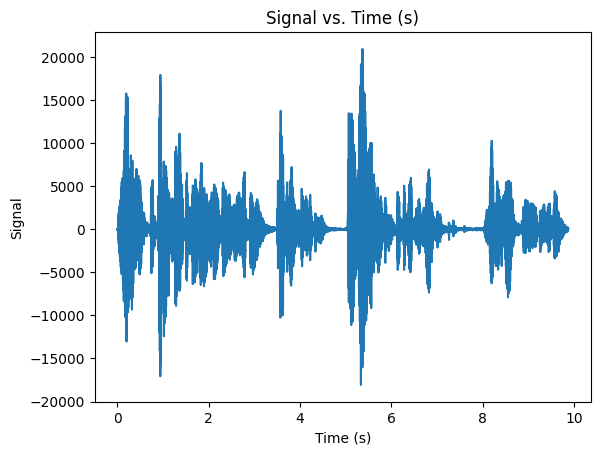

In [6]:
print('original # of samples: ', len(data), ' @ sampling frequency: ', FS)

MAX_FS = 16000 # set max frequency to 16kHz
if FS > MAX_FS: # cap sampling frequency at 16kHz
    NUM_SAMPLES = round(len(data) * float(MAX_FS) / FS) # reduce # of samples by ratio of sampling frequencies
    data = signal.resample(data, NUM_SAMPLES) # resample at reduced sampling frequency
    FS = MAX_FS # set sampling frequency to 16kHz

print('new # of samples: ', len(data), ' @ sampling frequency: ', FS)

# plot downsampled wave
plt.figure('downsampled wave')
plt.title('Signal vs. Time (s)')
plt.xlabel('Time (s)')
plt.ylabel('Signal')
plt.plot(create_timestamps(data, FS), data)
plt.show()

MAX_AMP = 20000 # set max volume of output wave to be 20log(20000) ≈ 86 dB
output_signal_as_wav('downsampled', data, FS, MAX_AMP)

## Time Chunking

**Design choices to consider**
- number of chunks
- duration of chunks
- gaps / overlap between chunks

**Assumptions**
- let duration of all chunks be the same, and let order of magnitude of duration be from 10^-2 to 10^-3
    - having non-equal duration will make it difficult to tune chunk size to get a desired output because it will add variance and thus randomness
- let parameters be set such that maximal amount of signal is inputted into chunks (i.e. no gaps, use enough chunks to get through majority of signal duration)
    - cutting out signal is hypothesized to reduce intelligibility (analogous to muting an audio file every x milliseconds, thus hypothesized to be unlikely to contribute to robotic effect, but this will be tested for confirmation)

**Test Cases**
- few chunks of longer duration vs. many chunks of short duration
    1. 20ms chunk duration
    2. 10ms chunk duration
    3. 5ms chunk duration
- gap size
    1. no gap
    2. small gap (1/1000th of the duration of a consonant ≈ 200ms (https://wordcounter.net/blog/2016/06/02/101702_how-fast-average-person-speaks.html))
    3. large gap (1/100th of the duration of a consonant)
- overlap
    1. no overlap (same as no gap)
    2. small overlap (1/1000th of the duration of a consonant)
    3. large overlap (1/100th of the duration of a consonant)

chunk time duration (ms):  15.0
samples in each chunk:  240 

gap time duration (ms):  0
samples in each gap:  0 

overlap time duration (ms):  0
samples in each overlap:  0 

number of chunks:  657 

last allowable sample index:  157680
minimum leftover samples, should be less than 240:  216 

length of data array:  157896
final data index:  157440
leftover samples, should be less than 240:  456 

shape of chunk array, should be (657, 240):  (657, 240)


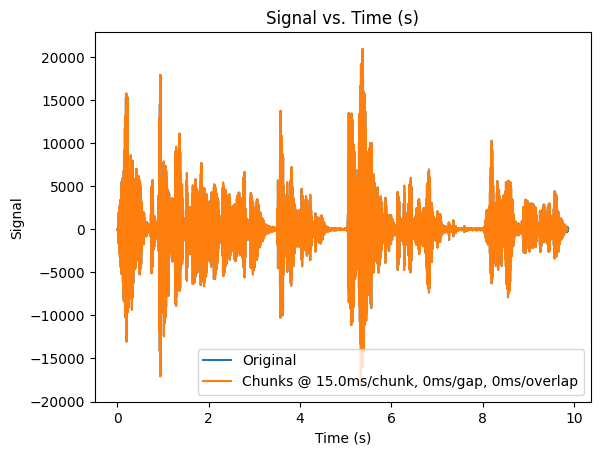

In [7]:
# CHUNK_TIME_DURATION = 20 / 1000 # 20 ms
CHUNK_TIME_DURATION = 15 / 1000 # 10 ms
# CHUNK_TIME_DURATION = 5 / 1000 # 5 ms
NUM_SAMPLES_PER_CHUNK = int(FS * CHUNK_TIME_DURATION) # samples / chunk = (samples / second) * (seconds / chunk)

print('chunk time duration (ms): ', CHUNK_TIME_DURATION * 1000)
print('samples in each chunk: ', NUM_SAMPLES_PER_CHUNK, '\n')

GAP_TIME_DURATION = 0 # no gap
# GAP_TIME_DURATION = 1/1000 * 200/1000 # 1/1000th of a consonant in seconds
# GAP_TIME_DURATION = 1/100 * 200/1000 # 1/100th of a consonant in seconds
# GAP_TIME_DURATION = 1/50 * 200/1000 # 1/100th of a consonant in seconds

OVERLAP_TIME_DURATION = 0 # no overlap
# OVERLAP_TIME_DURATION = 1/1000 * 200/1000 # 1/1000th of a consonant in seconds
# OVERLAP_TIME_DURATION = 1/100 * 200/1000 # 1/10th of a consonant in seconds
# OVERLAP_TIME_DURATION = 1/50 * 200/1000 # 1/10th of a consonant in seconds

NUM_SAMPLES_PER_GAP = int(FS * GAP_TIME_DURATION) # samples / gap = (samples / second) * (seconds / gap)
NUM_SAMPLES_PER_OVERLAP = int(FS * OVERLAP_TIME_DURATION) # samples / overlap = (samples / second) * (seconds / overlap)

NUM_SAMPLES_PER_BLOCK = NUM_SAMPLES_PER_CHUNK + NUM_SAMPLES_PER_GAP - NUM_SAMPLES_PER_OVERLAP

print('gap time duration (ms): ', GAP_TIME_DURATION * 1000)
print('samples in each gap: ', NUM_SAMPLES_PER_GAP, '\n')

print('overlap time duration (ms): ', OVERLAP_TIME_DURATION * 1000)
print('samples in each overlap: ', NUM_SAMPLES_PER_OVERLAP, '\n')

NUM_CHUNKS = len(data) // (NUM_SAMPLES_PER_BLOCK) # truncate to prevent indexing beyond available samples in data array
print('number of chunks: ', NUM_CHUNKS, '\n')

LAST_SAMPLE_INDEX = NUM_CHUNKS * (NUM_SAMPLES_PER_BLOCK) # define end condition when iterating over data array by calculating max index that leads to a complete chunk
print('last allowable sample index: ', LAST_SAMPLE_INDEX)
print(f'minimum leftover samples, should be less than {NUM_SAMPLES_PER_CHUNK}: ', len(data) - LAST_SAMPLE_INDEX, '\n') # check that minimum leftover samples don't fit into a full chunk (ensures no chunks are wasted)


chunk_array = np.empty((NUM_CHUNKS, NUM_SAMPLES_PER_CHUNK)) # initialize n x m array, n chunks each containing m samples
chunk_index = 0 # set up index to insert samples into correct chunk (between 0 and NUM_CHUNKS)
data_index = 0 # set up index to find data from original data array (between 0 and LAST_SAMPLE_INDEX)

# loop over data array while there are enough samples left to fill a complete chunk
while data_index + NUM_SAMPLES_PER_CHUNK < LAST_SAMPLE_INDEX:
    # fill a chunk with NUM_SAMPLES_PER_CHUNK samples
    for i in range(0, NUM_SAMPLES_PER_CHUNK):
        chunk_array[chunk_index, i] = data[data_index + i]
    chunk_index += 1 # increment to next chunk
    data_index += NUM_SAMPLES_PER_BLOCK # increment to next block to sample data from

print('length of data array: ', len(data))
print('final data index: ', data_index) # confirm that last index taken from data array is smaller than total samples available (avoid sampling data that doesn't exist)
print(f'leftover samples, should be less than {NUM_SAMPLES_PER_CHUNK}: ', len(data) - data_index, '\n')

print(f'shape of chunk array, should be ({NUM_CHUNKS}, {NUM_SAMPLES_PER_CHUNK}): ', chunk_array.shape) # final chunk array should have shape as defined earlier

# validate chunking by graphing flattened chunks vs. original signal to see if they look similar
flattened_chunks = chunk_array.flatten()
plt.figure('chunked wave (flattened) vs. original wave')
plt.title('Signal vs. Time (s)')
plt.xlabel('Time (s)')
plt.ylabel('Signal')
plt.plot(create_timestamps(data, FS), data, label = 'Original')
plt.plot(create_timestamps(flattened_chunks, FS), flattened_chunks, label = f'Chunks @ {CHUNK_TIME_DURATION*1000}ms/chunk, {GAP_TIME_DURATION*1000}ms/gap, {OVERLAP_TIME_DURATION*1000}ms/overlap')
plt.legend()
plt.show()

# validate chunking by listening to output wave and ensuring it is intelligible
output_signal_as_wav('chunked', flattened_chunks, FS, MAX_AMP)

### Frequency Spectra

Observations:
- In first two plots, majority of frequency content is within 0 to 1kHz, very little content beyond 7kHz
- For overall signal, amplitude ranges from 0 to ~175 
- For chunks, amplitudes range from 0 to ~13k

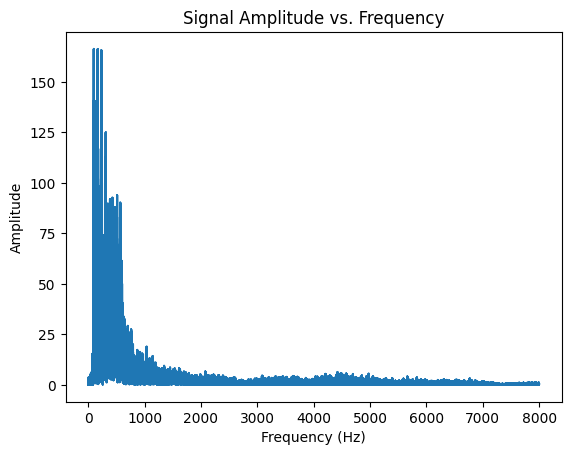

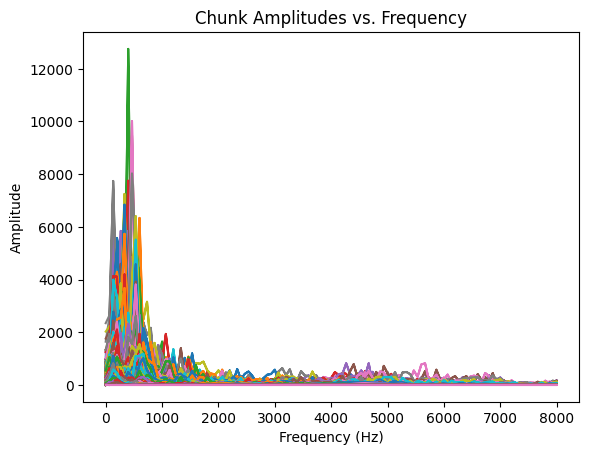

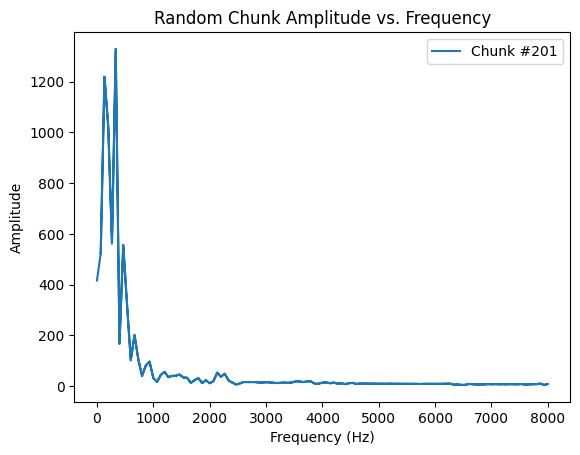

In [8]:
freq, amp = fft(flattened_chunks, FS)
plt.figure('signal frequency spectrum')
plt.title('Signal Amplitude vs. Frequency')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.plot(freq, amp)
plt.show()

plt.figure('chunk frequency spectra')
plt.title('Chunk Amplitudes vs. Frequency')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')

for chunk in chunk_array:
    chunk_freq, chunk_amp = fft(chunk, FS)
    plt.plot(chunk_freq, chunk_amp, label='first chunk')
plt.show()

# rand_index = np.random.randint(0, NUM_CHUNKS)
rand_index = 200
plt.figure('random chunk frequency spectrum')
plt.title('Random Chunk Amplitude vs. Frequency')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
rand_chunk_freq, rand_chunk_amp = fft(chunk_array[rand_index], FS)
plt.plot(rand_chunk_freq, rand_chunk_amp, label=f'Chunk #{rand_index + 1}')
plt.legend()
plt.show()

### Frequency Filtering

**Design choices to consider**
- center frequency
- filter type (butterworth vs. chebyshev type I vs. elliptic)
    (https://www.researchgate.net/publication/320518598_IDENTIFICATION_OF_PHARMACEUTICAL_SUBSTANCES_WITH_RAMAN_SPECTROSCOPY)
- filter order
- bandwidth
- number of filters
- gaps / overlap between filters

**Assumptions**
- Assuming bandwidth of filters are relatively small (order of magnitude from 10^1 to 10^3 Hz), center frequency can be middle of band, as there shouldn't be much variation in resulting pitch, and attenuation at center of pass band should be quite low for all viable filter types
- Limit filter order to order of magnitude from 10^1 to 10^2 to ensure reasonable computation time
- Let number of filters be calculated using bandwidth and max frequency (`sampling rate / 2` by Nyquist Criterion) to cover a proportion of the entire spectrum
    - e.g. if bandwidth is 100 and sampling rate is 16000, 100% of spectrum is covered using `(16000 / 2) / 100` filters

**Test Cases**
- filter type
    1. butterworth
    2. chebyshev type I
    3. elliptic
- filter order
    1. low order (N = 1)
    2. mid order (N = 4)
    3. high order (N = 12)
- bandwidth
    1. large bandwidth (BW = 250)
    2. mid bandwidth (BW = 50)
    3. small bandwidth (BW = 10)
- number of filters
    1. 100% (bands go up to ~8kHz)
    2. 50% (bands go up to ~4kHz)
    3. 25% (bands go up to ~2kHz)
- gap size
    1. no gap
    2. small gap (10 Hz)
    3. large gap (100 Hz)
- overlap
    1. no overlap (same as no gap)
    2. small overlap (10 Hz)
    3. large overlap (100 Hz)

In [9]:
# to generate bank of filters, need to know type, start and end frequency (from bandwidth), gap / overlap between filters, and number of filters

# FILTER_TYPE = 'butterworth'
FILTER_TYPE = 'chebyshev1'
# FILTER_TYPE = 'elliptic'

FILTER_ORDER = 1
# FILTER_ORDER = 4
# FILTER_ORDER = 12

# BW = 250
# BW = 50
BW = 25

GAP_WIDTH = 0 # no gap
# GAP_WIDTH = 5 # 5 Hz
# GAP_WIDTH = 10 # 10 Hz
# GAP_WIDTH = 100 # 100 Hz

OVERLAP_WIDTH = 0 # no overlap
# OVERLAP_WIDTH = 5 # 5 Hz
# OVERLAP_WIDTH = 10 # 10 Hz
# OVERLAP_WIDTH = 100 # 100 Hz

PERCENT_SPECTRUM = 100.0 # filters cover ~100% of usable spectrum
# PERCENT_SPECTRUM = 50.0 # filters cover ~50% of usable spectrum
# PERCENT_SPECTRUM = 25.0 # filters cover ~25% of usable spectrum

NYQUIST_FREQ = FS / 2
print('Nyquist Frequency: ', NYQUIST_FREQ, '\n')

START_FREQ = 1
MAX_FILTERS = NYQUIST_FREQ // (BW + GAP_WIDTH - OVERLAP_WIDTH) # max bandwidth / (bandwidth / filter + gap / filter - overlap / filter) = max filters (truncated to avoid going over Nyquist freq)
NUM_FILTERS = int(MAX_FILTERS * (PERCENT_SPECTRUM / 100)) # use percent of max to limit percent of spectrum used in frequency bands

print('Max number of filters: ', MAX_FILTERS)
print('Current number of filters: ', NUM_FILTERS)
print(f'Percentage of spectrum covered by filters, should be ~{PERCENT_SPECTRUM}%: {((NUM_FILTERS * (BW + GAP_WIDTH - OVERLAP_WIDTH)) / NYQUIST_FREQ) * 100}%\n')

LOW_CUTOFF_FREQ = 1 # start lower cutoff frequency at 1 Hz since signal cannot be <= 0 Hz
HIGH_CUTOFF_FREQ = LOW_CUTOFF_FREQ + BW # upper cutoff frequency is one bandwidth higher than lower cutoff
CENTER_FREQ = LOW_CUTOFF_FREQ + BW / 2 # center is halfway from lower cutoff to higher cutoff

filter_dimensions = np.shape(signal.butter(N=FILTER_ORDER, Wn=[LOW_CUTOFF_FREQ, HIGH_CUTOFF_FREQ], btype='bandpass', fs=FS, output='sos')) # get shape of scipy filter outputs to initialize an array for storing filters
filter_array_dimensions = (NUM_FILTERS,) + filter_dimensions # combine tuples to create n-element tuple describing n-dimensional array
filter_array = np.zeros(filter_array_dimensions) # create array to store filters

center_freq_array = np.zeros(NUM_FILTERS) # store the center frequency of each frequency band to use later for synthesizing the robot voice

# fill filter array with filters using given filter type, order, and lower/upper cutoff frequencies
for i in range(0,NUM_FILTERS):
    if HIGH_CUTOFF_FREQ >= NYQUIST_FREQ: HIGH_CUTOFF_FREQ = NYQUIST_FREQ - 1 # allow last bin to go up to just before Nyquist frequency (results in smaller bandwidth than others)
    
    if FILTER_TYPE == 'butterworth':
        filter_array[i] = signal.butter(N=FILTER_ORDER, Wn=[LOW_CUTOFF_FREQ, HIGH_CUTOFF_FREQ], btype='bandpass', fs=FS, output='sos')
    elif FILTER_TYPE == 'chebyshev1':
        filter_array[i] = signal.cheby1(N=FILTER_ORDER, rp=0.5, Wn=[LOW_CUTOFF_FREQ, HIGH_CUTOFF_FREQ], btype='bandpass', fs=FS, output='sos')
    elif FILTER_TYPE == 'elliptic':
        filter_array[i] = signal.ellip(N=FILTER_ORDER, rp=0.5, rs=40, Wn=[LOW_CUTOFF_FREQ, HIGH_CUTOFF_FREQ], btype='bandpass', fs=FS, output='sos')
    else:
        print('Error! Invalid filter type!')
        break
    
    center_freq_array[i] = CENTER_FREQ
    
    LOW_CUTOFF_FREQ += BW + GAP_WIDTH - OVERLAP_WIDTH
    HIGH_CUTOFF_FREQ = LOW_CUTOFF_FREQ + BW
    CENTER_FREQ = LOW_CUTOFF_FREQ + BW / 2

print(f'Output of last filter in filter array, should not be zeros: ', filter_array[-1])
print(f'Last center frequency in filter array (should not be 0): ', center_freq_array[-1], '\n')

Nyquist Frequency:  8000.0 

Max number of filters:  320.0
Current number of filters:  320
Percentage of spectrum covered by filters, should be ~100.0%: 100.0%

Output of last filter in filter array, should not be zeros:  [[ 0.01276348  0.         -0.01276348  1.          1.97446938  0.97447304]]
Last center frequency in filter array (should not be 0):  7988.5 



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

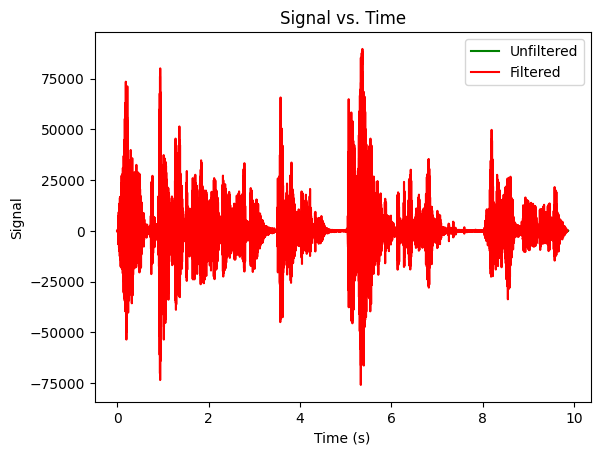

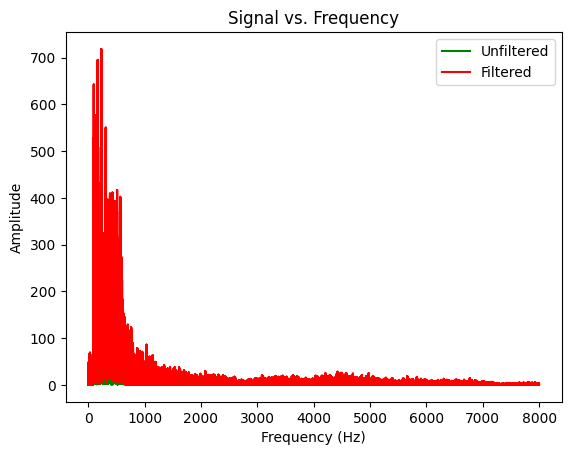

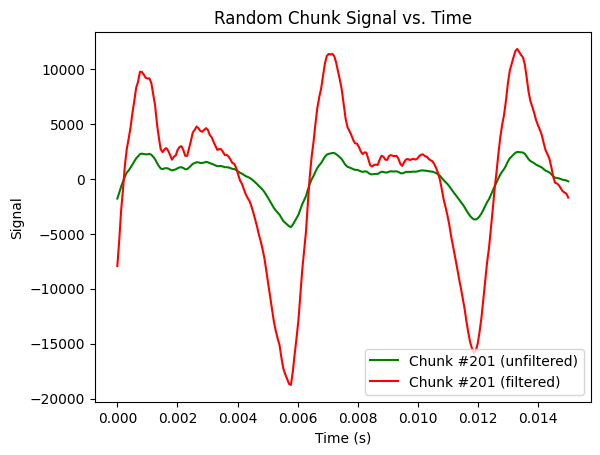

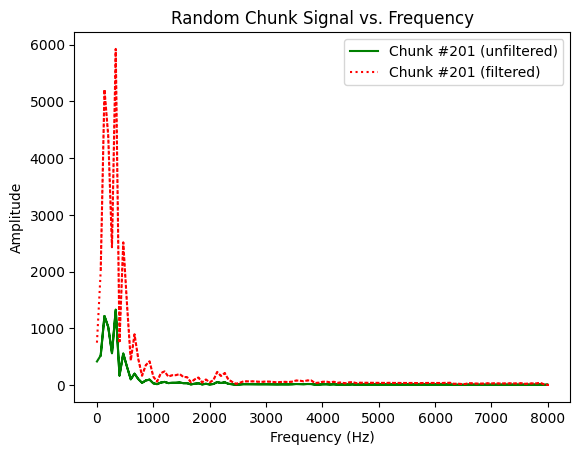

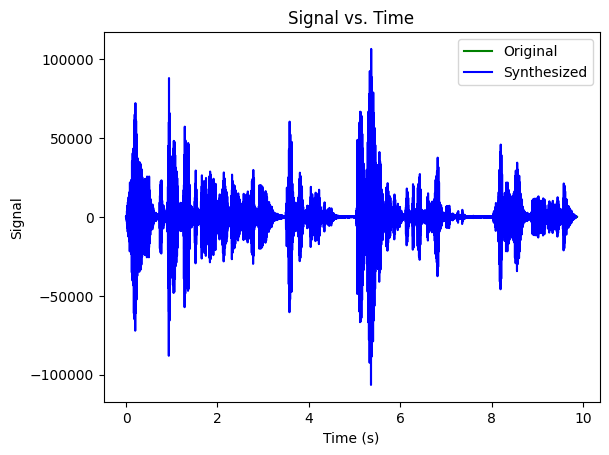

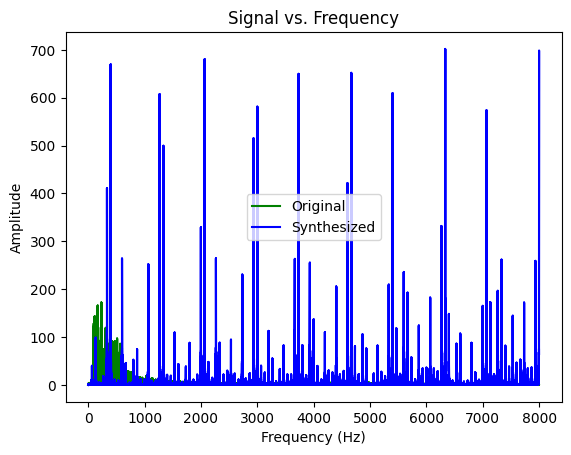

In [10]:
# chunk_index = np.random.randint(0, NUM_CHUNKS)
chunk_index = 200

random_chunk_filtered_output = np.zeros(NUM_SAMPLES_PER_CHUNK) # initialize array of zeros to be summed to with length = num samples per chunk to use for debugging

TOTAL_SAMPLES = NUM_CHUNKS * NUM_SAMPLES_PER_BLOCK # total number of samples in final output (accounting for gaps and overlaps between chunks)

filtered_output = np.zeros(TOTAL_SAMPLES) # initialize array of zeros to be summed to with length = total samples to use for validating filtering
synthesized_output = np.zeros(TOTAL_SAMPLES) # initialize array of zeros to to be summed to with length = total samples to use to generate robot voice

# THRESHOLD_POWER = 30

# iterate through each time chunk
for i in range(0, np.shape(chunk_array)[0]):
    print(i) # track progress of code execution
    
    chunk = chunk_array[i] # grab current data chunk in time domain
    chunk_start_index_in_output = i * NUM_SAMPLES_PER_BLOCK # calculate start timestamp for this chunk
    chunk_end_index_in_output = chunk_start_index_in_output + NUM_SAMPLES_PER_CHUNK # calculate end timestamp for this chunk
    
    # apply each filter to this chunk
    for j in range(0, len(filter_array)):
        freq_filter = filter_array[j]
        filtered_chunk = signal.sosfilt(freq_filter, chunk) # apply current filter to current chunk
        RMS = np.sqrt(np.mean(filtered_chunk ** 2)) # calculate power (root mean square) of current filtered chunk
        # if i % 50 == 0 and j % 50 == 0: print('RMS: ', RMS)
        
        # edge case: trying to extend output beyond upper bound on output
        if chunk_end_index_in_output > TOTAL_SAMPLES:
            leftover_samples = TOTAL_SAMPLES - chunk_start_index_in_output # calculate leftover samples that fit in output
            filtered_output[chunk_start_index_in_output:TOTAL_SAMPLES] += filtered_chunk[:leftover_samples] # add filtered samples that fit in output
            
            # if RMS < THRESHOLD_POWER: continue # skip adding this signal to the synth output if RMS is below a certain power threshold
            
            synth_wave_timestamps = np.linspace(2*np.pi*center_freq_array[j]*chunk_start_index_in_output, 2*np.pi*center_freq_array[j]*TOTAL_SAMPLES, leftover_samples) # calculate NUM_SAMPLES_PER_CHUNK inputs for synth sine wave in radians up to upper bound
            synth_wave = RMS*np.sin(synth_wave_timestamps) # generate synth wave up to upper bound timestamp using RMS as amplitude
            synthesized_output[chunk_start_index_in_output:TOTAL_SAMPLES] += synth_wave # add current synthesized wave to overall synthesized output at corresponding timestamps
            continue
        
        filtered_output[chunk_start_index_in_output:chunk_end_index_in_output] += filtered_chunk # add current filtered chunk to output at correct timestamp
        
        # save sample filtered chunk for debugging
        if i == chunk_index:
            random_chunk_filtered_output += filtered_chunk
        
        # if RMS < THRESHOLD_POWER: continue # skip adding this signal to the synth output if RMS is below a certain power threshold
        synth_wave_timestamps = np.linspace(2*np.pi*center_freq_array[j]*chunk_start_index_in_output, 2*np.pi*center_freq_array[j]*chunk_end_index_in_output, NUM_SAMPLES_PER_CHUNK) # calculate NUM_SAMPLES_PER_CHUNK inputs for synth sine wave in radians using center frequency
        synth_wave = RMS*np.sin(synth_wave_timestamps) # generate synth wave using inputs and RMS as amplitude
        synthesized_output[chunk_start_index_in_output:chunk_end_index_in_output] += synth_wave # add current synthesized sine wave to overall synthesized output at corresponding timestamps

# plot filtered signal and compare it to original in time domain
plt.figure('filtered signal vs. time')
plt.plot(create_timestamps(data, FS), data, label='Unfiltered', color='green')
plt.plot(create_timestamps(filtered_output, FS), filtered_output, color='red', label='Filtered')
plt.title('Signal vs. Time')
plt.ylabel('Signal')
plt.xlabel('Time (s)')
plt.legend()
plt.show()

# plot filtered signal and compare it to original in frequency domain
plt.figure('filtered signal vs. frequency')
freq, amp = fft(data, FS)
plt.plot(freq, amp, color='green', label='Unfiltered')
freq, amp = fft(filtered_output, FS)
plt.plot(freq, amp, color='red', label='Filtered')
plt.title('Signal vs. Frequency')
plt.ylabel('Amplitude')
plt.xlabel('Frequency (Hz)')
plt.legend()
plt.show()

# plot filtered signal from one chunk and compare to original chunk in time domain
plt.figure('random chunk filtered vs. unfiltered time domain')
plt.title('Random Chunk Signal vs. Time')
plt.ylabel('Signal')
plt.xlabel('Time (s)')
plt.plot(create_timestamps(chunk_array[chunk_index], FS), chunk_array[chunk_index], color='green', label=f'Chunk #{chunk_index + 1} (unfiltered)')
plt.plot(create_timestamps(random_chunk_filtered_output, FS), random_chunk_filtered_output, color='red', label=f'Chunk #{chunk_index + 1} (filtered)')
plt.legend()
plt.show()

# plot filtered signal from one chunk and compare to original chunk in frequency domain
plt.figure('random chunk filtered vs. unfiltered frequency spectra')
plt.title('Random Chunk Signal vs. Frequency')
plt.ylabel('Amplitude')
plt.xlabel('Frequency (Hz)')
freq, amp = fft(chunk_array[chunk_index], FS)
plt.plot(freq, amp, color='green', label=f'Chunk #{chunk_index + 1} (unfiltered)')
freq, amp = fft(random_chunk_filtered_output, FS)
plt.plot(freq, amp, linestyle='dotted', color='red', label=f'Chunk #{chunk_index + 1} (filtered)')
plt.legend()
plt.show()

# validate filtering by listening to output wave and ensuring it is intelligible
output_signal_as_wav('filtered', filtered_output, FS, MAX_AMP)

# plot synthesized signal and compare it to original in time domain
plt.figure('synthesized signal vs. time')
plt.plot(create_timestamps(data, FS), data, color='green', label='Original')
plt.plot(create_timestamps(synthesized_output, FS), synthesized_output, color='blue', label='Synthesized')
plt.title('Signal vs. Time')
plt.ylabel('Signal')
plt.xlabel('Time (s)')
plt.legend()
plt.show()

# plot synthesized signal and compare it to original in frequency domain
plt.figure('synthesized signal vs. frequency')
freq, amp = fft(data, FS)
plt.plot(freq, amp, color='green', label='Original')
freq, amp = fft(synthesized_output, FS)
plt.plot(freq, amp, color='blue', label='Synthesized')
plt.title('Signal vs. Frequency')
plt.ylabel('Amplitude')
plt.xlabel('Frequency (Hz)')
plt.legend()
plt.show()

# validate synthesizing by listening to output wave and ensuring it is robotic
output_signal_as_wav('robot', synthesized_output, FS, MAX_AMP)

In [11]:
# # THRESHOLD_POWER = 1

# output_signal = np.array([])

# counter = 1

# # TOTAL_OUTPUT_POWER = 0

# for chunk in chunk_array:
#     if (counter == 200): break
#     print(counter)
#     counter += 1
    
#     RMS_list = []

#     for freq_bin in range(0, NUM_FREQ_BINS):
#         F_LOW = START_FREQ + freq_bin * BW
#         F_HIGH = START_FREQ + BW + freq_bin * BW
#         sos_bandpass = signal.butter(ORDER, [F_LOW, F_HIGH], btype='bandpass', fs=FS, output='sos')
#         filtered_bin_data = signal.sosfilt(sos_bandpass, chunk)
#         RMS_list.append(np.sqrt(np.mean(filtered_bin_data ** 2)))

#     RMS_raw = np.array(RMS_list)
#     RMS_filtered = []

#     NUM_SAMPLES_PER_CHUNK = int(FS*CHUNK_TIME_DURATION)
#     current_signal = np.zeros(NUM_SAMPLES_PER_CHUNK)

#     for i in range(0,NUM_FREQ_BINS):
#         if RMS_raw[i] > THRESHOLD_POWER:
#             RMS_filtered.append(RMS_raw[i])
            
#             chunk_time_start_output = i * CHUNK_TIME_DURATION
#             chunk_time_end_output = chunk_time_start_output + CHUNK_TIME_DURATION
#             f_c = START_FREQ + BW/2 + i * BW

#             chunk_time = np.linspace(2*np.pi*f_c*chunk_time_start_output, 2*np.pi*f_c*chunk_time_end_output, NUM_SAMPLES_PER_CHUNK)

#             current_signal = np.add(current_signal, RMS_raw[i] * np.sin(chunk_time))
        
#         else: RMS_filtered.append(0)

#     output_signal = np.append(output_signal, current_signal)

# print('sample: ', np.shape(np.array(sample)))

# output_for_wave = MAX_AMP*output_signal / np.max(output_signal) # new maximum is now 255

# x = np.linspace(0, len(output_for_wave) / FS, len(output_for_wave))

# plt.plot(x, output_for_wave)
# plt.show()

# dataout = np.asarray(output_for_wave, dtype=np.int16) # to integer type 16

# wavfile.write('robot.wav',FS,dataout)